In [1]:
using LimberJack
using Plots
using Turing
using QuadGK
using Interpolations

## Data

In [2]:
# Generate some fake data
# Try different cosmologies
cosmo = LimberJack.Cosmology(Ωm=0.27, Ωb=0.04, h=0.7, σ8=0.77);
z_integ = cosmo.settings.zs;

In [3]:
z_hz_data  = sort(2.5 .* rand(30))
hz_data    = cosmo.cpar.h*Ez(cosmo, z_hz_data)
hz_err = 0.1 .* hz_data
z_dm_data  = sort(2.5 .* rand(300))
dm_data    = cosmo.chi(z_dm_data)
dm_err = 0.1 .* dm_data
z_fs8_data = sort(2.5 .* rand(20))
fs8_data   = cosmo.fs8z(z_fs8_data);
fs8_err = 0.1 .* fs8_data;

hz_lcdm = cosmo.cpar.h*Ez(cosmo, z_integ)
dm_lcdm = cosmo.chi(z_integ)
fs8_lcdm = cosmo.fs8z(z_integ);

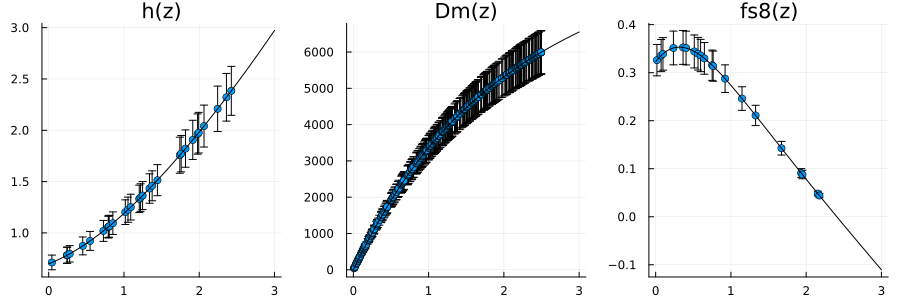

In [4]:
# Create the plots
p1 = plot(z_hz_data, hz_data, yerr=hz_err, seriestype=:scatter,title="h(z)", legend=false)
p2 = plot(z_dm_data, dm_data, yerr=dm_err, seriestype=:scatter, title="Dm(z)", legend=false)
p3 = plot(z_fs8_data, fs8_data, yerr=fs8_err, seriestype=:scatter, title="fs8(z)", legend=false)

plot!(p1, z_integ, hz_lcdm, color=:black)
plot!(p2, z_integ, dm_lcdm, color=:black)
plot!(p3, z_integ, fs8_lcdm, color=:black)

# Combine them horizontally (1 row, 3 columns)
plot(p1, p2, p3, layout=(1,3), size=(900,300))

## Modelling

In [5]:
# Let's now do some modelling
function Dm_from_Ez(ez, z_in, h)
    chis = similar(ez)
    # Annoyingly, we have to build an interpolator for quadgk
    ez_itp = LinearInterpolation(z_integ, ez, extrapolation_bc=Line())
    for i in 1:length(z_in)
        zz = z_in[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h
    end
    return chis
end

function fs8_from_Ez(e, z_in, Ωm, σ8)
    nz = length(z_in)
    a = @.(1/(1+z_in))
    x = log.(1 .+ z_in)
    dx = x[2]-x[1]
    
    aa = reverse(a)
    ee = reverse(e)
    dd = fill!(similar(e), 0)
    yy = fill!(similar(e), 0)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]
    
    for i in 1:(nz-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx*yy[i] + (1+0.5*dx^2*A0*B0)*dd[i]
    end
    
    y = reverse(yy)
    d = reverse(dd)
    fs8z = -σ8 .* y./ (a.^2 .*e.*d[1])

    return fs8z
end

fs8_from_Ez (generic function with 1 method)

In [6]:
ez_lcdm = hz_lcdm ./ hz_lcdm[1] 
dm_test = Dm_from_Ez(ez_lcdm, z_integ, hz_lcdm[1])
fs8_test = fs8_from_Ez(ez_lcdm, z_integ, cosmo.cpar.Ωm, cosmo.cpar.σ8);

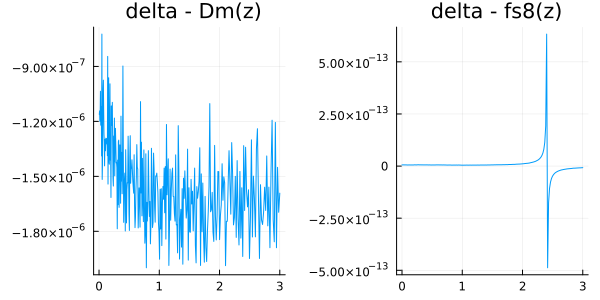

In [7]:
# Compare output
p1 = plot(z_integ, (dm_test .- dm_lcdm)./dm_lcdm,  title=" delta - Dm(z)", legend=false)
p2 = plot(z_integ, (fs8_test .- fs8_lcdm)./fs8_lcdm, title=" delta - fs8(z)", legend=false)

# Combine them horizontally (1 row, 2 columns)
plot(p1, p2, layout=(1,2), size=(600,300))

## Inference

In [8]:
# concatenate all data
using LinearAlgebra
z_data = vcat(z_hz_data, z_dm_data, z_fs8_data)
data = vcat(hz_data, dm_data, fs8_data)
data_err = vcat(hz_err, dm_err, fs8_err)
data_cov = Diagonal(data_err .^2);

In [9]:
@model function model(data)
    # Priors
    Ωm ~ Uniform(0.1, 0.5)
    h ~ Uniform(0.6, 0.8)
    σ8 ~ Uniform(0.6, 0.9)
    
    # Create cosmology
    cosmo = LimberJack.Cosmology(Ωm=Ωm, Ωb=0.04, h=h, σ8=σ8);
    
    # Model predictions
    ez_model := Ez(cosmo, z_integ)
    hz_model := h .* ez_model
    # Gaussian Process would go here
    dm_model := Dm_from_Ez(ez_model, z_integ, h)
    fs8_model := fs8_from_Ez(ez_model, z_integ, Ωm, σ8)

    hz_itp = LinearInterpolation(z_integ, hz_model, extrapolation_bc=Line())
    dm_itp = LinearInterpolation(z_integ, dm_model, extrapolation_bc=Line())
    fs8_itp = LinearInterpolation(z_integ, fs8_model, extrapolation_bc=Line())

    hz_theory = hz_itp(z_hz_data)
    dm_theory = dm_itp(z_dm_data)
    fs8_theory = fs8_itp(z_fs8_data)

    theory = vcat(hz_theory, dm_theory, fs8_theory)

    # Likelihood
    data .~ MvNormal(theory, data_cov)
end

model (generic function with 2 methods)

In [10]:
cond_model = model(data)
n_samples = 100
chain = sample(cond_model, NUTS(0.65), n_samples)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (100×1215×1 Array{Float64, 3}):

Iterations        = 51:1:150
Number of chains  = 1
Samples per chain = 100
Wall duration     = 19.96 seconds
Compute duration  = 19.96 seconds
parameters        = Ωm, h, σ8, ez_model[1], ez_model[2], ez_model[3], ez_model[4], ez_model[5], ez_model[6], ez_model[7], ez_model[8], ez_model[9], ez_model[10], ez_model[11], ez_model[12], ez_model[13], ez_model[14], ez_model[15], ez_model[16], ez_model[17], ez_model[18], ez_model[19], ez_model[20], ez_model[21], ez_model[22], ez_model[23], ez_model[24], ez_model[25], ez_model[26], ez_model[27], ez_model[28], ez_model[29], ez_model[30], ez_model[31], ez_model[32], ez_model[33], ez_model[34], ez_model[35], ez_model[36], ez_model[37], ez_model[38], ez_model[39], ez_model[40], ez_model[41], ez_model[42], ez_model[43], ez_model[44], ez_model[45], ez_model[46], ez_model[47], ez_model[48], ez_model[49], ez_model[50], ez_model[51], ez_model[52], ez_model[53], ez_model[54], ez_model[55], ez_model[56], 